In [1]:
ls ../dnftresult

OneDCyclic_mlp1layer_nonDim_baseline/  OneDsignal_mlp1layer_Dimside_baseline/
OneDsignal_fordebug_baseline/          OneDsignal_mlp1layer_baseline/
OneDsignal_mask1layer_baseline/        OneDsignal_mlp1layer_nonDim_baseline/


./dataset/oneDsignal_data.py
[0, 2, 4, 8, 16, 32]
0


100%|██████████| 33/33 [00:01<00:00, 27.56it/s]


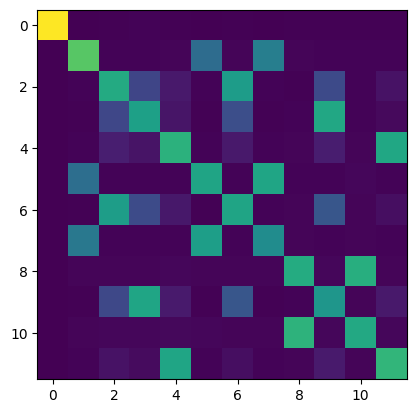

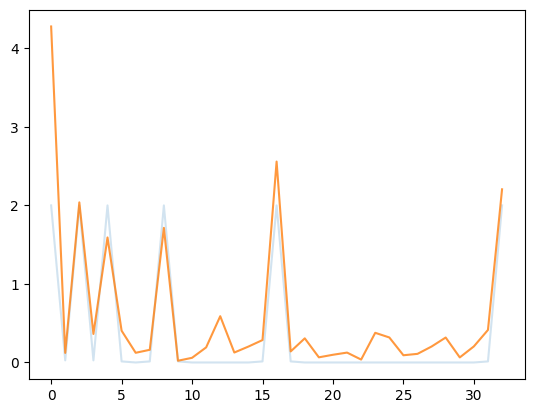

In [27]:
import sys
import yaml

sys.path.append("./")
import os
import torch
from misc import yaml_util as yu
import numpy as np

sys.path.append("../dataset")
sys.path.append("../module")
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from misc import character_analysis as ca
from misc import loss_helper as lh
import pdb
import copy
from module import ft_decimation as ftd

import time


datname = "OneDsignal_c8mimic_lowpow"
modelname = "Plambda_OneD_RotFeat1layer_ver3"

trainname = "faster"
with open(f"""../cfg_data/{datname}.yaml""", "rb") as f:
    cfg_data = yaml.safe_load(f)

cfg_data["args"]["shift_label"] = True
mydata = yu.load_component(cfg_data)

expname = f"""{datname}_{modelname}_{trainname}"""

exppath = os.path.join("../dnftresult", expname)

mymodelpath = f"""{exppath}/model.pt"""
mymodel = torch.load(mymodelpath)


myloader = DataLoader(
    mydata,
    batch_size=32,
    shuffle=True,
    num_workers=2,
)


Ms = {0: [], 1: []}
shifts = []

if hasattr(mymodel, "nftlayers"):
    mynft = mymodel.nftlayers[0]
else:
    mynft = mymodel

if hasattr(mydata, "nfreq"):
    for k in range(10):
        evalseq, shift = next(iter(myloader))
        evalseq = evalseq[:, :2].to(mynft.encoder.device)
        predicted = mymodel(evalseq, n_rolls=1)
        shifts.append(shift)
        Ms[0].append(mynft.dynamics.M)

    shifts = torch.concatenate(shifts)
    Ms[0] = torch.concatenate(Ms[0]).detach()

    plt.figure()

    matrixMeanshape = torch.mean(torch.abs(Ms[0].detach()).to("cpu"), axis=0)

    plt.imshow(matrixMeanshape)

    myfreqs = np.array(mydata.freqsel)
    maxfreq = np.max(myfreqs)

    targfreq, prods0 = ca.inner_prod(
        Ms[0].to(shifts.device), shifts, maxfreq=maxfreq, bins=maxfreq + 1
    )

    plt.figure()
    deltas = ca.deltafxn(targfreq, mydata.freqsel) * 2
    plt.plot(
        targfreq,
        deltas,
        alpha=0.2,
        label="gt:" + str(np.where(deltas > 1.0)[0]),
    )
    targfreq, prods0 = ca.inner_prod(
        Ms[0].to(shifts.device), shifts, maxfreq=maxfreq, bins=maxfreq + 1
    )
    plt.plot(
        targfreq,
        prods0,
        label="pred0:" + str(np.where(prods0 > 1.0)[0]),
        alpha=0.8,
    )



In [28]:
Ms[0].shape

torch.Size([320, 12, 12])

In [51]:
mypermute=  [[0], [1,5,7], [2,6], [3,9], [4,11], [8 ,10]]

In [52]:
import itertools 
mysort =  list(itertools.chain(*mypermute))

In [53]:
myMs =  Ms[0][:, mysort, :][:, :, mysort]

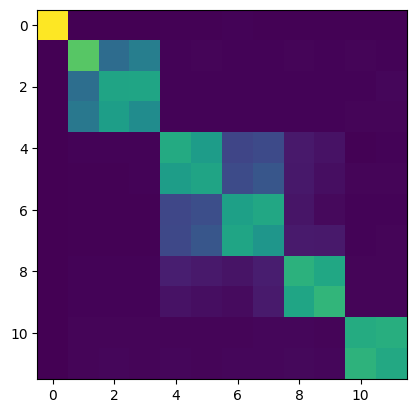

In [54]:
plt.figure()

matrixMeanshape = torch.mean(torch.abs(myMs.detach()).to("cpu"), axis=0)

plt.imshow(matrixMeanshape)

In [44]:
mysort

[0, 1, 5, 7, 2, 3, 6, 9, 4, 11, 8, 10]

100%|██████████| 33/33 [00:01<00:00, 28.23it/s]
/tmp/ipykernel_508348/717317806.py:8: MatplotlibDeprecationWarning: Passing label as a length 3 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(
100%|██████████| 33/33 [00:01<00:00, 28.13it/s]
/tmp/ipykernel_508348/717317806.py:8: MatplotlibDeprecationWarning: Passing label as a length 2 sequence when plotting a single dataset is deprecated in Matplotlib 3.9 and will error in 3.11.  To keep the current behavior, cast the sequence to string before passing.
  plt.plot(
100%|██████████| 33/33 [00:01<00:00, 28.12it/s]


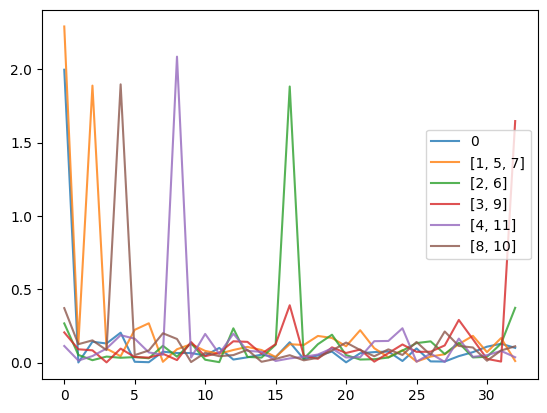

In [60]:
plt.figure() 
for k in range(len(mypermute)):  
    myslice = mypermute[k]
    checkM =  Ms[0][:, myslice, :][:, :, myslice]
    targfreq, prods0 = ca.inner_prod(
        checkM.to(shifts.device), shifts, maxfreq=maxfreq, bins=maxfreq + 1
    )
    plt.plot(
        targfreq,
        prods0,
        label=myslice,
        alpha=0.8,
    )    
plt.legend()

In [61]:
mymodel

DFNFT(
  (nftlayers): ModuleList(
    (0): NFT(
      (encoder): MM_MLPEncoder(
        (activation_fxn): Tanh()
        (net): Sequential(
          (0): Linear(in_features=128, out_features=132, bias=True)
          (1): MM_MaskFlatLinear()
          (2): Tanh()
          (3): MM_MaskFlatLinear()
          (4): Tanh()
          (5): MM_MaskFlatLinear()
        )
      )
      (decoder): MM_MLPDecoder(
        (activation_fxn): Tanh()
        (net): Sequential(
          (0): MM_MaskFlatLinear()
          (1): Tanh()
          (2): MM_MaskFlatLinear()
          (3): Tanh()
          (4): MM_MaskFlatLinear()
          (5): Linear(in_features=132, out_features=128, bias=True)
        )
      )
      (PLambdaNet): RotFeatureModule(
        (rlnet): Sequential(
          (0): RotatingLinear(
            (fc): Linear(in_features=12, out_features=12, bias=False)
            (norm): LayerNorm((12,), eps=1e-05, elementwise_affine=True)
          )
          (1): RotatingLinear(
            (f